In [48]:
#importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt # we'll need this later
from scipy.io import loadmat

mat = loadmat("ex5data1.mat") #used to load mat files
Xtrain = mat["X"]
xval = mat["Xval"]
xtest = mat["Xtest"]


ytrain = mat["y"].squeeze()
yval = mat["yval"].squeeze()
ytest = mat["ytest"].squeeze()

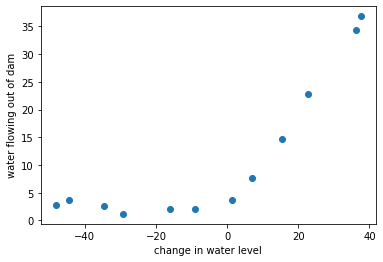

In [49]:
#plotting a scatterplot for our data set
plt.scatter(Xtrain,ytrain)
plt.xlabel('change in water level')
plt.ylabel('water flowing out of dam')
plt.show()

In [50]:
#defining cost function, gradient and train_linear_regression function which will optimize our parameters theta
def costFunction(theta, X, y):
    predictions = X @ theta
    return np.sum(np.square(predictions - y)) / (2 * len(y))

def gradientDescent(theta, X, y):
    predictions = X @ theta
    return X.transpose() @ (predictions - y) / len(y)

def train_linear_regression(X, y):
    theta = np.zeros(X.shape[1]) # initialize model parameters with zeros
    return opt.fmin_cg(costFunction, theta, gradientDescent, (X, y), disp=False)

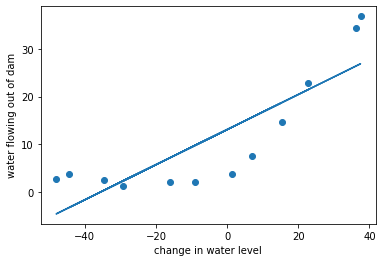

In [51]:
#training and plotting our linear regression model
m,n = Xtrain.shape
X_train = np.hstack((np.ones((m,1)),Xtrain))
theta = train_linear_regression(X_train, ytrain)
plt.scatter(X_train[:,1],ytrain)
plt.xlabel('change in water level')
plt.ylabel('water flowing out of dam')
hypothesis = X_train @ theta
plt.plot(X_train[:,1],hypothesis)
plt.show()

In [52]:
#plotting learning curves to analyse bias/variance
def learning_curves(Xtrain,ytrain,Xval,yval):
    train_error = np.zeros(len(ytrain))
    val_error = np.zeros(len(ytrain))
    
    for i in range(1,len(ytrain)):
        theta = train_linear_regression(Xtrain[0:i + 1, :], ytrain[0:i + 1])
        train_error[i] = costFunction(theta, Xtrain[0:i + 1, :], ytrain[0:i + 1])
        val_error[i] = costFunction(theta, Xval, yval)
    
    plt.plot(range(2, len(ytrain)+1), train_error[1:], c = 'r', linewidth = 2)
    plt.plot(range(2, len(ytrain)+1), val_error[1:], c = 'b', linewidth = 2)
    plt.xlabel('m training examples')
    plt.ylabel('error')
    plt.legend(['training','validation'], loc = 'best')
    plt.axis([2, len(ytrain), 0, 100])
    plt.grid()

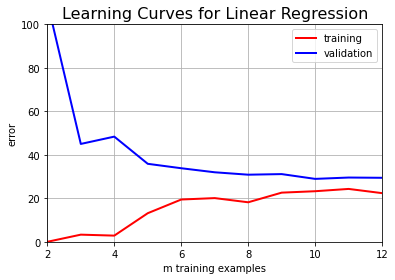

In [53]:
k,l = xval.shape
x_val = np.hstack((np.ones((k,1)),xval))
plt.title("Learning Curves for Linear Regression", fontsize=16)
learning_curves(X_train, ytrain, x_val, yval)

In [54]:
#since our model is underfitting(from learning curves) we will introduce polynomial features
def poly_features(x, degree):
    X_poly = np.zeros(shape=(len(x), degree))
    for i in range(0, degree):
        X_poly[:, i] = x.squeeze() ** (i + 1);
    return X_poly

In [55]:
X_train_poly = poly_features(Xtrain,8)
X_val_poly = poly_features(xval,8)
X_test_poly = poly_features(xtest, 8)

In [56]:
#normalizing examples in the dataset
train_mean = X_train_poly.mean(axis = 0)
train_std = np.std(X_train_poly,axis = 0,ddof =1)

X_train_poly = (X_train_poly - train_mean) / train_std
X_val_poly = (X_val_poly - train_mean) / train_std
X_test_poly = (X_test_poly - train_mean) / train_std

a,b = xtest.shape

X_train_poly = np.hstack((np.ones((m,1)),X_train_poly))
X_val_poly = np.hstack((np.ones((k,1)),X_val_poly))
X_test_poly = np.hstack((np.ones((a,1)),X_test_poly))
def insert_ones(x):
    X = np.ones(shape=(x.shape[0], x.shape[1] + 1))
    X[:, 1:] = x
    return X


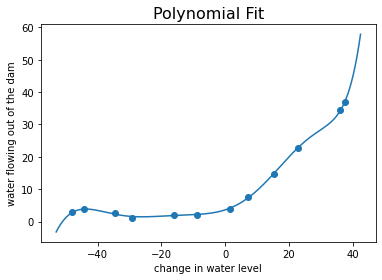

In [57]:
#plotting polynomial regression model
def plot_fit(min_x,max_x,mean,std,theta,degree):
    x = np.linspace(min_x - 5, max_x +5,1000)
    x_poly = poly_features(x,degree)
    x_poly = (x_poly - mean)/ std
    x_poly = insert_ones(x_poly)
    plt.plot(x, x_poly @ theta)
    plt.show()
    
theta = train_linear_regression(X_train_poly,ytrain)
plt.scatter(Xtrain, ytrain)
plt.xlabel("change in water level")
plt.ylabel("water flowing out of the dam")
plt.title("Polynomial Fit", fontsize=16)
plot_fit(min(Xtrain), max(Xtrain), train_mean, train_std, theta, 8)

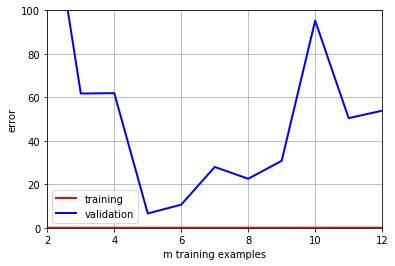

In [58]:
learning_curves(X_train_poly,ytrain,X_val_poly,yval)

In [59]:
#since our model overfits the data we will introduce regularization now
def cost(theta, X, y, lamb=0):
    predictions = X @ theta
    squared_errors = np.sum(np.square(predictions - y))
    regularization = np.sum(lamb * np.square(theta[1:]))
    return (squared_errors + regularization) / (2 * len(y))

def cost_gradient(theta, X, y, lamb=0):
    predictions = X @ theta
    gradient = X.transpose() @ (predictions - y)
    regularization = lamb * theta
    regularization[0] = 0 # don't penalize the intercept term
    return (gradient + regularization) / len(y)

def train_linear_regression(X, y, lamb=0):
    theta = np.zeros(X.shape[1])
    return opt.fmin_cg(cost, theta, cost_gradient, (X, y, lamb), disp=False)

In [60]:
def learning_curves(X_train, y_train, X_val, y_val, lamb=0):
    train_err = np.zeros(len(y_train))
    val_err = np.zeros(len(y_train))
    for i in range(1, len(y_train)):
        theta = train_linear_regression(X_train[0:i + 1, :], y_train[0:i + 1], lamb)
        train_err[i] = cost(theta, X_train[0:i + 1, :], y_train[0:i + 1])
        val_err[i] = cost(theta, X_val, y_val)
    plt.plot(range(2, len(y_train) + 1), train_err[1:], c="r", linewidth=2)
    plt.plot(range(2, len(y_train) + 1), val_err[1:], c="b", linewidth=2)
    plt.xlabel("number of training examples", fontsize=14)
    plt.ylabel("error", fontsize=14)
    plt.legend(["Training", "Validation"], loc="best")
    plt.axis([2, len(y_train), 0, 100])
    plt.grid()

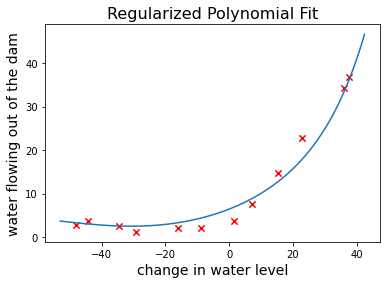

In [63]:
theta = train_linear_regression(X_train_poly, ytrain, 1)
plt.scatter(Xtrain, ytrain, marker="x", s=40, c='red')
plt.xlabel("change in water level", fontsize=14)
plt.ylabel("water flowing out of the dam", fontsize=14)
plt.title("Regularized Polynomial Fit", fontsize=16)
plot_fit(min(Xtrain), max(Xtrain), train_mean, train_std, theta, 8)

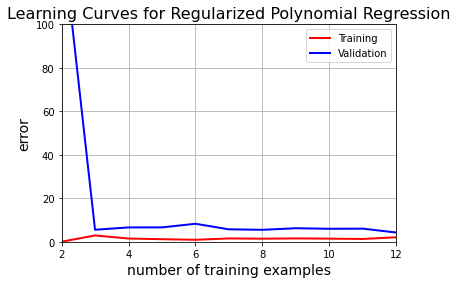

In [64]:
plt.title("Learning Curves for Regularized Polynomial Regression", fontsize=16)
learning_curves(X_train_poly, ytrain, X_val_poly, yval, 1)